In [48]:
import numpy as np
import torch
from torch import nn
import torch.distributions as dist
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [49]:
%config InlineBackend.figure_format = 'retina'
sns.set()

# Make data

In [50]:
np.random.seed(123)

# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0 #1.0

# Generate and plot data
x = 10 * np.random.rand(100)
mu = alpha + beta * x
y = np.random.normal(mu, scale=sigma)

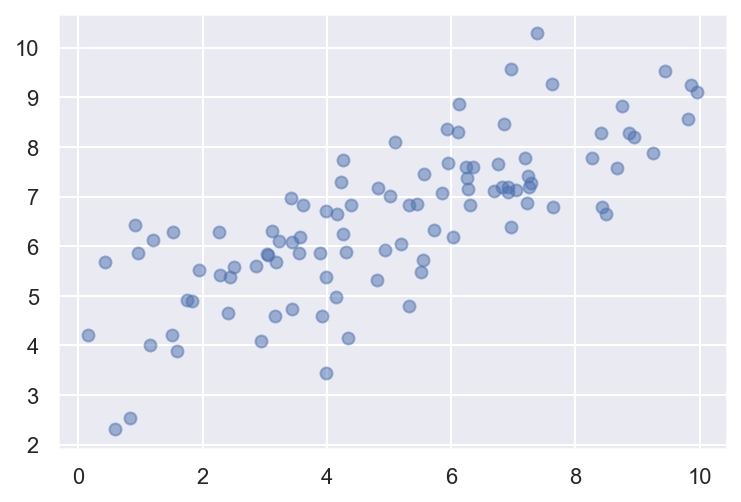

In [51]:
plt.scatter(x, y, alpha=0.5);

In [52]:
idx = np.argsort(x)
x = x[idx]
y = y[idx]
X = torch.tensor(x[:, None], dtype=torch.float)
Y = torch.tensor(y[:, None], dtype=torch.float)

# Maximum likelihood

## Not modeling noise

In [53]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.zeros(1))
        self.beta = nn.Parameter(torch.zeros(1))
            
    def forward(self, x):
        y_pred = self.alpha + self.beta* x
        return y_pred

In [54]:
model = LinearRegression()
for name, param in model.named_parameters():
    print(
        f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 



In [55]:
def det_loss(y_pred):
    return torch.square(y_pred - Y).sum()

In [56]:
epochs = 5000

optim = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = model(X)
    loss = det_loss(y_pred)
    loss.backward()
    optim.step()

In [57]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([4.1693], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.4732], grad_fn=<SliceBackward>) 



## Modeling Noise

In [58]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.zeros(1))
        self.beta = nn.Parameter(torch.zeros(1))
        self.sigma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        y_pred = self.alpha + self.beta* x
        return y_pred
    
    def log_lik(self, x, y_pred):
        mu = self.alpha + self.beta*x
        sg = self.sigma.exp()
        likelihood = dist.Normal(mu, sg).log_prob(Y)
        return likelihood.sum()
    
    def loss(self, x, y_pred):
        return -self.log_lik(x, y_pred) 

In [59]:
model = LinearRegression()
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 

Layer: sigma | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 



In [60]:
epochs = 5000

optim = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = model(X)
    loss = model.loss(X, y_pred)
    loss.backward()
    optim.step()

In [61]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([4.1699], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.4731], grad_fn=<SliceBackward>) 

Layer: sigma | Size: torch.Size([1]) | Values : tensor([-0.0219], grad_fn=<SliceBackward>) 



In [62]:
np.exp(-0.0219)

0.9783380639660794

# Variational inference: Univariate Gaussian

## Maximum likelihood

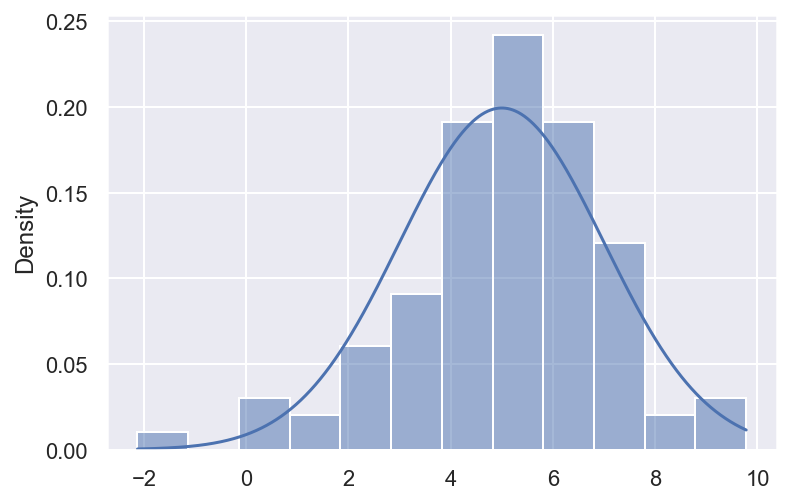

In [145]:
mu = 5
sigma = 2
N = 1000
np.random.seed(1234)

x_dist = scipy.stats.norm(loc=mu, scale=sigma)

x = x_dist.rvs(size=100)
x_pdf = np.linspace(np.min(x), np.max(x), N)
pdf = x_dist.pdf(x_pdf)

fig, ax = plt.subplots()
sns.histplot(x, bins='auto', stat='density', alpha=0.5)
ax.plot(x_pdf, pdf);

In [146]:
class Gaussian(nn.Module):
    
    def __init__(self, x):
        super().__init__()
        self.X = torch.tensor(x[:, None], dtype=torch.float)
        self.alpha = nn.Parameter(torch.zeros(1))
        self.beta = nn.Parameter(torch.zeros(1))
    
    def log_lik(self):
        mu = self.alpha
        sg = self.beta.exp()
        likelihood = dist.Normal(mu, sg).log_prob(self.X)
        return likelihood.sum()
    
    def loss(self):
        return -self.log_lik() 

In [147]:
model = Gaussian(x)
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 



In [148]:
epochs = 5000

optim = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    loss = model.loss()
    loss.backward()
    optim.step()

In [149]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([5.0702], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.6888], grad_fn=<SliceBackward>) 



In [150]:
np.exp(0.6888)

1.9913245095043566

## VI

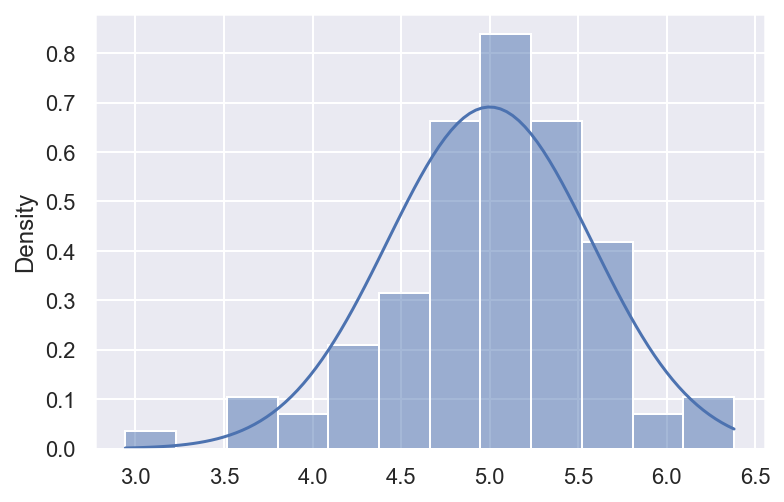

In [220]:
mu = 5
precision = 3
N = 100
np.random.seed(1234)

x_dist = scipy.stats.norm(loc=mu, scale=np.sqrt(1/precision))

x = x_dist.rvs(size=N)
x_pdf = np.linspace(np.min(x), np.max(x), 100)
pdf = x_dist.pdf(x_pdf)

fig, ax = plt.subplots()
sns.histplot(x, bins='auto', stat='density', alpha=0.5)
ax.plot(x_pdf, pdf);

$$ {\begin{aligned}\tau &\sim \operatorname {Gamma} (a_{0},b_{0})\\\mu &\sim {\mathcal {N}}(\mu _{0},(\lambda _{0}\tau )^{-1})\\\{x_{1},\dots ,x_{N}\}&\sim {\mathcal {N}}(\mu ,\tau ^{-1})\\N&={\text{number of data points}}\end{aligned}}$$

$$ {\begin{aligned}q_{\mu }^{*}(\mu )&\sim {\mathcal {N}}(\mu \mid \mu _{N},\lambda _{N}^{-1})\\\mu _{N}&={\frac {\lambda _{0}\mu _{0}+N{\bar {x}}}{\lambda _{0}+N}}\\\lambda _{N}&=(\lambda _{0}+N)\operatorname {E} _{\tau }[\tau ]\\{\bar {x}}&={\frac {1}{N}}\sum _{n=1}^{N}x_{n}\end{aligned}}$$

$$ {\begin{aligned}q_{\tau }^{*}(\tau )&\sim \operatorname {Gamma}(\tau \mid a_{N},b_{N})\\a_{N}&=a_{0}+{\frac  {N+1}{2}}\\b_{N}&=b_{0}+{\frac  {1}{2}}\operatorname {E}_{\mu }\left[\sum _{{n=1}}^{N}(x_{n}-\mu )^{2}+\lambda _{0}(\mu -\mu _{0})^{2}\right]\end{aligned}}$$

In [234]:
lambda0 = 1
mu0 = 0
a0 = 1
b0 = 1

sum_x = x.sum()
sum_x2 = (x**2).sum()

mu_n = (lambda0*mu0 + sum_x) / (lambda0 + N)
a_n = a0 + (N+1)/2

lambda_n = 1
b_n = 1

i = 0
while True:
    
    b_brakets = (lambda0 + N)*(1/lambda_n + mu_n**2) \
        - 2*(lambda0*mu0+sum_x)*mu_n + sum_x2 + lambda0*mu0**2 
    new_b_n = b0 + 0.5*b_brakets

    diff_b_n = new_b_n - b_n
    b_n = new_b_n
    
    new_lambda_n = (lambda0 + N) * (a_n/b_n)
    
    diff_lambda_n = new_lambda_n - lambda_n
    lambda_n = new_lambda_n
        
    print(f"[step {i}] diff b_n = {np.abs(diff_b_n):.5f}")
    print(f"[step {i}] diff lambda_n = {np.abs(diff_lambda_n):.5f}")
    
    if np.abs(diff_lambda_n) < 1e-05 and np.abs(diff_b_n) < 1e-05:
        break
        
    i += 1

print(f'lambda_n', lambda_n)
print(f'b_n', b_n)

[step 0] diff b_n = 79.49994
[step 0] diff lambda_n = 63.61496
[step 1] diff b_n = 49.71845
[step 1] diff lambda_n = 104.36647
[step 2] diff b_n = 0.48270
[step 2] diff lambda_n = 2.69212
[step 3] diff b_n = 0.00469
[step 3] diff lambda_n = 0.02656
[step 4] diff b_n = 0.00005
[step 4] diff lambda_n = 0.00026
[step 5] diff b_n = 0.00000
[step 5] diff lambda_n = 0.00000
lambda_n 171.7003627413106
b_n 30.2940536464489


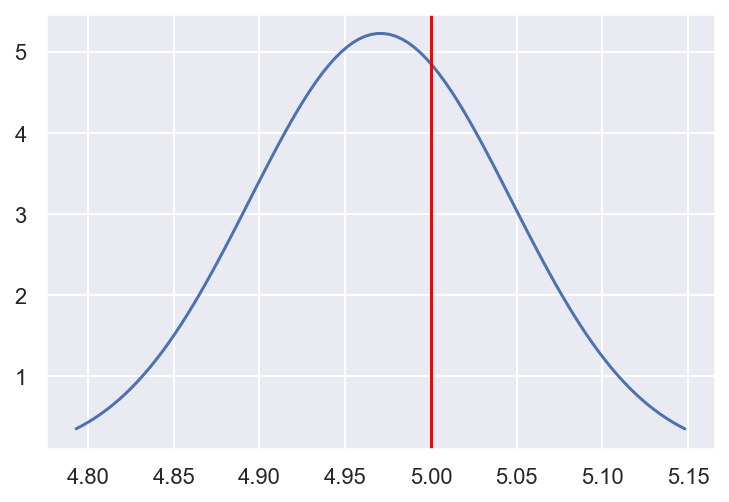

In [235]:
q_mu_dist = scipy.stats.norm(loc=mu_n, scale=np.sqrt(1/lambda_n))

x_plot = np.linspace(q_mu_dist.ppf(0.01), q_mu_dist.ppf(0.99), 100)
q_mu_pdf = q_mu_dist.pdf(x_plot)

fig, ax = plt.subplots()
ax.plot(x_plot, q_mu_pdf)
ax.axvline(mu, color='red');

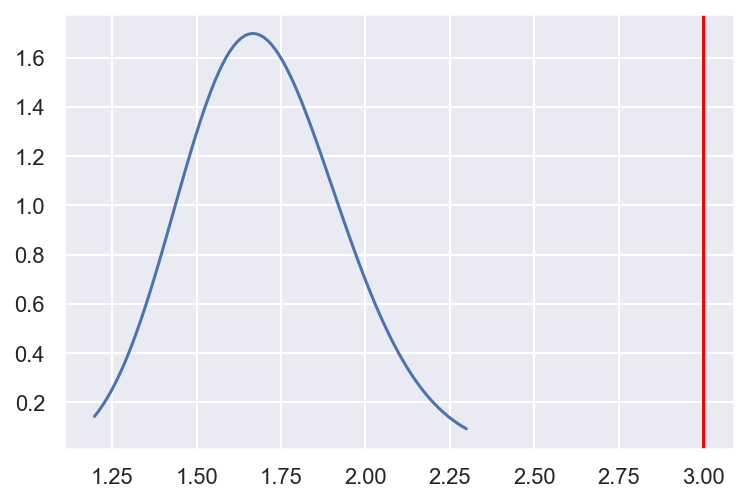

In [223]:
q_tau_dist = scipy.stats.gamma(a=a_n, scale=1/b_n)

x_plot = np.linspace(q_tau_dist.ppf(0.01), q_tau_dist.ppf(0.99), 100)
q_tau_pdf = q_tau_dist.pdf(x_plot)

fig, ax = plt.subplots()
ax.plot(x_plot, q_tau_pdf)
ax.axvline(precision, color='red');

In [224]:
mode_q_mu = mu_n
mode_q_tau = (a_n - 1)/b_n
print(mode_q_mu, mode_q_tau)

4.97056642189538 1.666993813022433


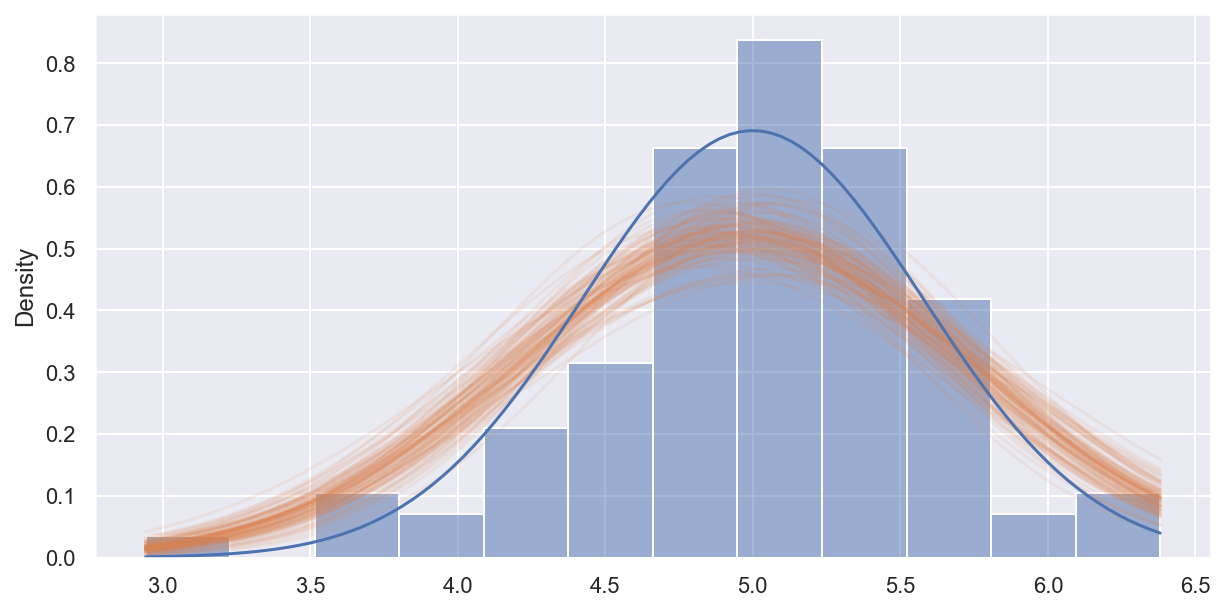

In [225]:
x_plot = np.linspace(np.min(x), np.max(x), 100)
x_pdf = x_dist.pdf(x_plot)

# est_x_pdf = scipy.stats.norm(loc=mode_q_mu, 
#                              scale=np.sqrt(1/mode_q_tau)).pdf(x_plot)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(x, bins='auto', stat='density', alpha=0.5)
# ax.plot(x_plot, est_x_pdf)

for i in range(100):
    sp_q_mu = q_mu_dist.rvs()
    sp_q_tau = q_tau_dist.rvs()
    est_x_pdf = scipy.stats.norm(
        loc=sp_q_mu, 
        scale=np.sqrt(1/sp_q_tau)).pdf(x_plot)
    ax.plot(x_plot, est_x_pdf, color='C1', alpha=0.1)
    
ax.plot(x_plot, x_pdf);

# Using Numpyro

In [226]:
import numpyro as npr
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, TraceMeanField_ELBO, autoguide
from numpyro.optim import Adam
from numpyro.infer.reparam import TransformReparam
from numpyro.distributions import constraints
from jax import random
import jax.numpy as jnp
import jax.scipy.special as jss
import scipy

In [250]:
def model():

    tau = npr.sample("tau", dist.Gamma(a0, b0))
    mu = npr.sample("mu",  dist.Normal(mu0, (1/(lambda0*tau))**0.5))
    with npr.plate("data", N):
        npr.sample("obs", dist.Normal(mu, (1/tau)**0.5), obs=y)

def guide():
    
    a_n = npr.param("a_n", 1.0, constraint=constraints.positive)
    b_n = npr.param("b_n", 1.0, constraint=constraints.positive)
            
    mu_n = npr.param("mu_n", 0.0)
    lambda_n = npr.param("lambda_n", 1.0, constraint=constraints.positive)
    
    npr.sample("tau", dist.Gamma(a_n, b_n))
    npr.sample("mu", dist.Normal(mu_n, (1/lambda_n)**0.5))

In [251]:
# set up the optimizer
optimizer = Adam(step_size=0.0005)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=TraceMeanField_ELBO())

svi_result = svi.run(random.PRNGKey(0), 100000)

100%|██████████| 100000/100000 [01:07<00:00, 1484.86it/s, init loss: 4100.8003, avg. loss [95001-100000]: 196.9726]


In [252]:
params = svi_result.params
params

{'a_n': DeviceArray(25.528908, dtype=float32),
 'b_n': DeviceArray(68.6, dtype=float32),
 'lambda_n': DeviceArray(37.644333, dtype=float32),
 'mu_n': DeviceArray(6.482311, dtype=float32)}

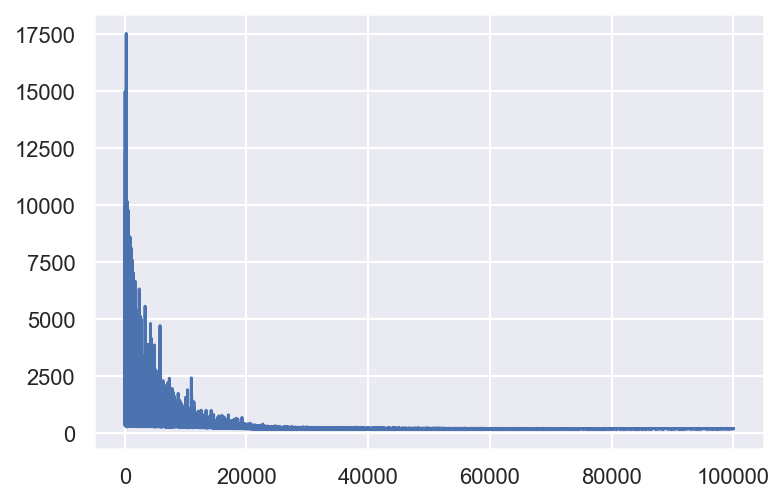

In [253]:
loss = svi_result.losses
plt.plot(loss)

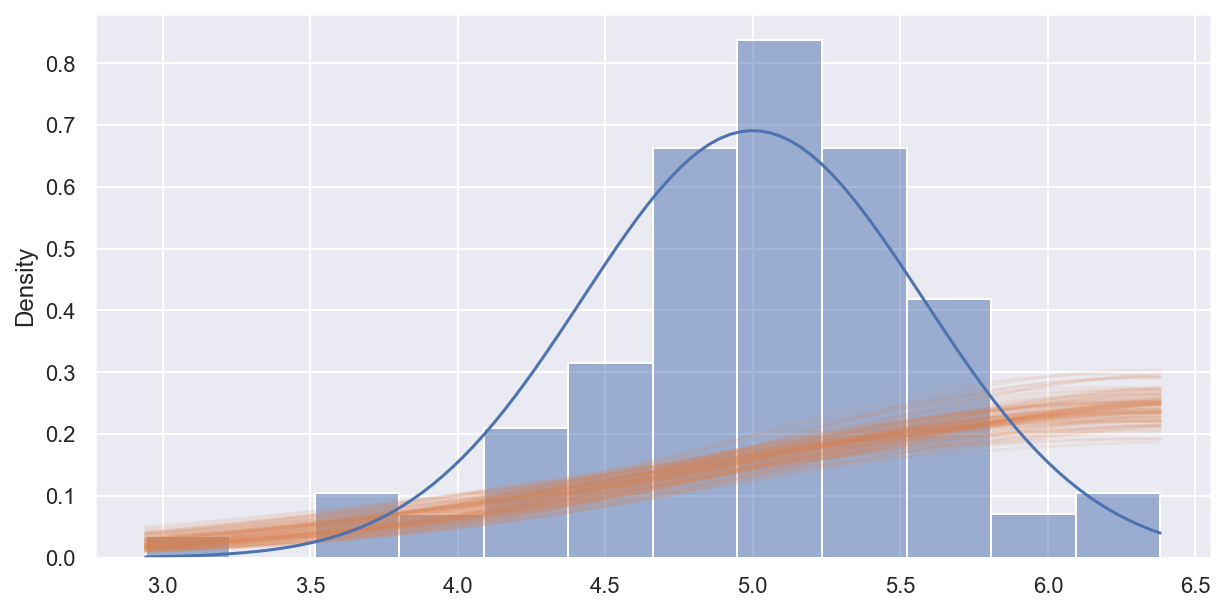

In [254]:
a_n = params['a_n'].item()
b_n = params['b_n'].item()
mu_n = params['mu_n'].item()
lambda_n = params['lambda_n'].item()

q_mu_dist = scipy.stats.norm(loc=mu_n, scale=(1/lambda_n)**0.5)
q_tau_dist = scipy.stats.gamma(a=a_n, scale=1/b_n)

x_plot = np.linspace(np.min(x), np.max(x), 100)
x_pdf = x_dist.pdf(x_plot)

# est_x_pdf = scipy.stats.norm(loc=mode_q_mu, 
#                              scale=np.sqrt(1/mode_q_tau)).pdf(x_plot)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(x, bins='auto', stat='density', alpha=0.5)
# ax.plot(x_plot, est_x_pdf)

for i in range(100):
    sp_q_mu = q_mu_dist.rvs()
    sp_q_tau = q_tau_dist.rvs()
    est_x_pdf = scipy.stats.norm(
        loc=sp_q_mu, 
        scale=np.sqrt(1/sp_q_tau)).pdf(x_plot)
    ax.plot(x_plot, est_x_pdf, color='C1', alpha=0.1)
    
ax.plot(x_plot, x_pdf);